In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import re
import ast
import seaborn as sns
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 4000

In [3]:
#Letters to iterate through
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']
#Empty lists to store our data
names_list = []
links_list = []
start_list = []
end_list = []
pos_list = []

In [4]:
for letter in alphabet:
    #Link to webpage using requests and BeautifulSoup
    page = requests.get('https://www.basketball-reference.com/players/' + letter)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    #Select The table then the rows
    table = soup.find('table', class_ = 'sortable stats_table')
    rows = table.findAll('tr')
    
    #Iterate through the rows and get all player names
    new_names_list = [row.find('th') for row in rows]
    new_names_list = [name.find('a') for name in new_names_list]
    new_names_list = [name for name in new_names_list if name]
    new_names_list = [name.string for name in new_names_list]
    
    #Iterate through the rows and get links to all player pages
    new_links_list = [row.find('th') for row in rows]
    new_links_list = [link.find('a') for link in new_links_list]
    new_links_list = [link for link in new_links_list if link]
    new_links_list = [link['href'] for link in new_links_list]
    
    #Iterate and get first year of a players career
    new_start_list = [row.findAll('td') for row in rows]
    new_start_list = [year for year in new_start_list if year]
    new_start_list = [year[0].string for year in new_start_list]
    
    #Iterate and get last year
    new_end_list = [row.findAll('td') for row in rows]
    new_end_list = [year for year in new_end_list if year]
    new_end_list = [year[1].string for year in new_end_list]
    
    #Iterate and get position
    new_pos_list = [row.findAll('td') for row in rows]
    new_pos_list = [pos for pos in new_pos_list if pos]
    new_pos_list = [pos[2].string.replace('-','') for pos in new_pos_list]
    
    #Add the new data to our lists
    names_list = names_list + new_names_list
    links_list = links_list + new_links_list
    start_list = start_list + new_start_list
    end_list = end_list + new_end_list
    pos_list = pos_list + new_pos_list
    
    
#Turn our lists into a dataframe and name the columns    
df = pd.DataFrame([names_list, links_list, start_list, end_list, pos_list]).transpose()
df.columns = ['Player', 'Link', 'StartYear', 'EndYear', 'Position']
df

,Player,Link,StartYear,EndYear,Position
0,Alaa Abdelnaby,/players/a/abdelal01.html,1991,1995,FC
1,Zaid Abdul-Aziz,/players/a/abdulza01.html,1969,1978,CF
2,Kareem Abdul-Jabbar,/players/a/abdulka01.html,1970,1989,C
3,Mahmoud Abdul-Rauf,/players/a/abdulma02.html,1991,2001,G
4,Tariq Abdul-Wahad,/players/a/abdulta01.html,1998,2003,F
...,...,...,...,...,...
4795,Ante Žižić,/players/z/zizican01.html,2018,2020,FC
4796,Jim Zoet,/players/z/zoetji01.html,1983,1983,C
4797,Bill Zopf,/players/z/zopfbi01.html,1971,1971,G
4798,Ivica Zubac,/players/z/zubaciv01.html,2017,2020,C


In [5]:
#Change data types of years to int64 and creating a column for amount of time in league
df.StartYear = df.StartYear.astype('int64')
df.EndYear = df.EndYear.astype('int64')
df['Tenure'] = df.EndYear - df.StartYear

In [6]:
df_eligible = df[(df.EndYear <= 2016) & (df.Tenure > 4)]
df_eligible.reset_index(inplace = True, drop = True)
#Limiting our data to players who retired in 2016 or earlier so that all players are hall of fame eligible
#Also removed any player who didn't last more than 4 seasons

In [7]:

def get_player_info(href1):
    page = requests.get('https://www.basketball-reference.com'+str(href1))
    #Name of Player
    #soup = BS(page.content, 'html.parser')
    #table_body=soup.find_all(itemprop= "name")
    #table_body
    #name= re.findall('<h1 itemprop=\"name\">(.*)</h1>', str(table_body))
    #if len(name)==0:
    #    name= re.findall('<span>(.*)</span>', str(table_body))
    #else:
    #    pass
    
    #Bio
    soup = BeautifulSoup(page.content, 'html.parser')
    table_body=soup.find_all('p')
    work=table_body[0:10]
    #print(work)
    height= re.findall('(\d*cm)', str(work))
    weight= re.findall('(\d*kg)', str(work))
    bday= re.findall('data-birth=\"(\d*\-\d*\-\d*)', str(work))
    #accolades
    accolades_body=soup.find(id="bling")
    All_Star_apps= re.findall('(\d*)x All Star', str(accolades_body))
    All_NBA_apps= re.findall('(\d*)x All-NBA', str(accolades_body))
    All_Def_apps= re.findall('(\d*)x All-Defensive', str(accolades_body))
    HOF= re.findall('(Hall of Fame)', str(accolades_body))
    empty_list=0
    if len(All_Star_apps)==empty_list:
        All_Star_apps='0'
    else:
        All_Star_apps=All_Star_apps[0]
    if len(All_NBA_apps)==empty_list:
        All_NBA_apps='0'
    else:
        All_NBA_apps=All_NBA_apps[0]
    if len(All_Def_apps)==empty_list:
        All_Def_apps='0'
    else:
        All_Def_apps= All_Def_apps[0]
    if len(HOF)==empty_list:
        HOF='0'
    else:
        HOF= HOF[0]
    bio= [height[0],weight[0],bday[0],All_Star_apps,All_NBA_apps,All_Def_apps,HOF]
    
    #Find Stats overview, then pull out individual stats then extract the stats and make them a list
    stats = soup.find('div', class_ = "stats_pullout")
    cells = stats.find_all('p')
    stats_list = list(map(lambda x : x.string, cells[3:23:2]))
    
    return bio + stats_list

In [8]:
info_list = [get_player_info(link) for link in df_eligible.Link]
#Very slow

In [9]:
df_info = pd.DataFrame(info_list, columns=['Height','Weight','Birthday','All_Star_apps','All_NBA_apps','All_Def_apps','HOF', 'Games', 'PPG', 'TRPG', 'APG', 'FG_pct', '3_pt_pct', 'FT_pct', 'eFG_pct', 'PER', 'WS'])
df_eligible = pd.concat([df_eligible, df_info], axis = 1)
df_eligible

#Concat the data about the players from info_list and the list of players

,Player,Link,StartYear,EndYear,Position,Tenure,Height,Weight,Birthday,All_Star_apps,All_NBA_apps,All_Def_apps,HOF,Games,PPG,TRPG,APG,FG_pct,3_pt_pct,FT_pct,eFG_pct,PER,WS
0,Zaid Abdul-Aziz,/players/a/abdulza01.html,1969,1978,CF,9,206cm,106kg,1946-04-07,0,0,0,0,505,9.0,8.0,1.2,42.8,72.8,15.1,17.5,None,None
1,Kareem Abdul-Jabbar,/players/a/abdulka01.html,1970,1989,C,19,218cm,102kg,1947-04-16,19,15,11,Hall of Fame,1560,24.6,11.2,3.6,55.9,5.6,72.1,55.9,24.6,273.4
2,Mahmoud Abdul-Rauf,/players/a/abdulma02.html,1991,2001,G,10,185cm,73kg,1969-03-09,0,0,0,0,586,14.6,1.9,3.5,44.2,35.4,90.5,47.2,15.4,25.2
3,Tariq Abdul-Wahad,/players/a/abdulta01.html,1998,2003,F,5,198cm,101kg,1974-11-03,0,0,0,0,236,7.8,3.3,1.1,41.7,23.7,70.3,42.2,11.4,3.5
4,Shareef Abdur-Rahim,/players/a/abdursh01.html,1997,2008,F,11,206cm,102kg,1976-12-11,1,0,0,0,830,18.1,7.5,2.5,47.2,29.7,81.0,47.9,19.0,71.2
5,Mark Acres,/players/a/acresma01.html,1988,1993,FC,5,211cm,99kg,1962-11-15,0,0,0,0,375,3.6,4.1,0.5,50.6,53.8,66.5,50.9,9.0,9.3
6,Alvan Adams,/players/a/adamsal01.html,1976,1988,CF,12,206cm,95kg,1954-07-19,1,0,0,0,988,14.1,7.0,4.1,49.8,13.3,78.8,49.8,18.3,73.5
7,Don Adams,/players/a/adamsdo01.html,1971,1977,F,6,198cm,95kg,1947-11-27,0,0,0,0,523,8.8,5.6,1.9,40.2,0.0,74.1,40.2,10.7,11.7
8,Michael Adams,/players/a/adamsmi01.html,1986,1996,G,10,178cm,73kg,1963-01-19,1,0,0,0,653,14.7,2.9,6.4,41.5,33.2,84.9,47.5,16.6,46.9
9,Rafael Addison,/players/a/addisra01.html,1987,1997,FG,10,201cm,97kg,1964-07-22,0,0,0,0,379,5.8,2.1,0.9,44.9,28.2,77.2,46.6,10.5,4.9


In [10]:
df_eligible.shape

(1458, 23)

In [11]:
page = requests.get("https://www.basketball-reference.com/players/n/ntilila01.html")
soup = BeautifulSoup(page.content, 'html.parser')

In [12]:
info = soup.find('div', id = 'meta')

In [59]:
cells = info.find_all("p")

In [14]:
cells

[<p><strong>Pronunciation</strong>: \Nee-Lee-Kee-Nuh\</p>,
 <p>
 <strong>
 <strong>Frank Bryan Ntilikina</strong>
 </strong>
     
   ▪
   <a href="/friv/twitter.html">Twitter</a>:
   <a href="https://twitter.com/FrankLikina">FrankLikina</a>
 </p>,
 <p>
 (Frankie Smokes, The Frenchise, The French Prince)
 </p>,
 <p>
 <strong>
   Position:
   </strong>
   Point Guard
 
 
   
   ▪
   
   <strong>
   Shoots:
   </strong>
   Right
 </p>,
 <p><span itemprop="height">6-4</span>, <span itemprop="weight">190lb</span> (193cm, 86kg) </p>,
 <p><strong>Team</strong>: <a href="/teams/NYK/2020.html">New York Knicks</a></p>,
 <p>
 <strong>Born: </strong>
 <span data-birth="1998-07-28" id="necro-birth" itemprop="birthDate">
 <a href="/friv/birthdays.fcgi?month=7&amp;day=28">July 28</a>,
             <a href="/friv/birthyears.fcgi?year=1998">1998</a>
 </span>
 <span itemprop="birthPlace">
     in Ixelles, <a href="/friv/birthplaces.fcgi?country=BE&amp;state=">Belgium</a></span>
 <span class="f-i f-be">

In [15]:
cells[3]

<p>
<strong>
  Position:
  </strong>
  Point Guard


  
  ▪
  
  <strong>
  Shoots:
  </strong>
  Right
</p>

In [16]:
cells[3].text

'\n\n  Position:\n  \n  Point Guard\n\n\n  \n  ▪\n  \n  \n  Shoots:\n  \n  Right\n'

In [17]:
cells[3].text.split()

['Position:', 'Point', 'Guard', '▪', 'Shoots:', 'Right']

In [22]:
df_eligible.isnull().sum().sort_values(ascending = False)

WS               240
PER              240
All_NBA_apps       0
Link               0
StartYear          0
EndYear            0
Position           0
Tenure             0
Height             0
Weight             0
Birthday           0
All_Star_apps      0
All_Def_apps       0
HOF                0
Games              0
PPG                0
TRPG               0
APG                0
FG_pct             0
3_pt_pct           0
FT_pct             0
eFG_pct            0
Player             0
dtype: int64

In [25]:
df_eligible = df_eligible.dropna(subset = ['WS', 'PER'])

In [26]:
df_eligible.isnull().sum().sort_values(ascending = False)

WS               0
All_NBA_apps     0
Link             0
StartYear        0
EndYear          0
Position         0
Tenure           0
Height           0
Weight           0
Birthday         0
All_Star_apps    0
All_Def_apps     0
PER              0
HOF              0
Games            0
PPG              0
TRPG             0
APG              0
FG_pct           0
3_pt_pct         0
FT_pct           0
eFG_pct          0
Player           0
dtype: int64

In [28]:
df_eligible

,Player,Link,StartYear,EndYear,Position,Tenure,Height,Weight,Birthday,All_Star_apps,All_NBA_apps,All_Def_apps,HOF,Games,PPG,TRPG,APG,FG_pct,3_pt_pct,FT_pct,eFG_pct,PER,WS
1,Kareem Abdul-Jabbar,/players/a/abdulka01.html,1970,1989,C,19,218cm,102kg,1947-04-16,19,15,11,Hall of Fame,1560,24.6,11.2,3.6,55.9,5.6,72.1,55.9,24.6,273.4
2,Mahmoud Abdul-Rauf,/players/a/abdulma02.html,1991,2001,G,10,185cm,73kg,1969-03-09,0,0,0,0,586,14.6,1.9,3.5,44.2,35.4,90.5,47.2,15.4,25.2
3,Tariq Abdul-Wahad,/players/a/abdulta01.html,1998,2003,F,5,198cm,101kg,1974-11-03,0,0,0,0,236,7.8,3.3,1.1,41.7,23.7,70.3,42.2,11.4,3.5
4,Shareef Abdur-Rahim,/players/a/abdursh01.html,1997,2008,F,11,206cm,102kg,1976-12-11,1,0,0,0,830,18.1,7.5,2.5,47.2,29.7,81.0,47.9,19.0,71.2
5,Mark Acres,/players/a/acresma01.html,1988,1993,FC,5,211cm,99kg,1962-11-15,0,0,0,0,375,3.6,4.1,0.5,50.6,53.8,66.5,50.9,9.0,9.3
6,Alvan Adams,/players/a/adamsal01.html,1976,1988,CF,12,206cm,95kg,1954-07-19,1,0,0,0,988,14.1,7.0,4.1,49.8,13.3,78.8,49.8,18.3,73.5
7,Don Adams,/players/a/adamsdo01.html,1971,1977,F,6,198cm,95kg,1947-11-27,0,0,0,0,523,8.8,5.6,1.9,40.2,0.0,74.1,40.2,10.7,11.7
8,Michael Adams,/players/a/adamsmi01.html,1986,1996,G,10,178cm,73kg,1963-01-19,1,0,0,0,653,14.7,2.9,6.4,41.5,33.2,84.9,47.5,16.6,46.9
9,Rafael Addison,/players/a/addisra01.html,1987,1997,FG,10,201cm,97kg,1964-07-22,0,0,0,0,379,5.8,2.1,0.9,44.9,28.2,77.2,46.6,10.5,4.9
11,Mark Aguirre,/players/a/aguirma01.html,1982,1994,FG,12,198cm,105kg,1959-12-10,3,0,0,0,923,20.0,5.0,3.1,48.4,31.2,74.1,49.8,19.0,67.8


In [44]:
all_time_scorers = df_eligible[['Player', 'PPG', 'Height']].groupby(['Player']).sum()
all_time_scorers = all_time_scorers.reset_index()
all_time_scorers.columns = ['Player', 'PPG', 'Height']
all_time_scorers = all_time_scorers.sort_values(by='PPG', ascending=False).head(20)
all_time_scorers

,Player,PPG,Height
569,Jim McElroy,9.9,190cm
921,Raja Bell,9.9,196cm
836,Mike James,9.9,188cm
226,Chucky Atkins,9.9,180cm
1067,Spud Webb,9.9,168cm
994,Ronald Murray,9.9,193cm
1063,Sonny Parker,9.9,198cm
472,Harvey Grant,9.9,203cm
607,John Mengelt,9.8,188cm
441,Gheorghe Mureșan,9.8,231cm


Text(0.5, 1.0, '# of Players By Position')

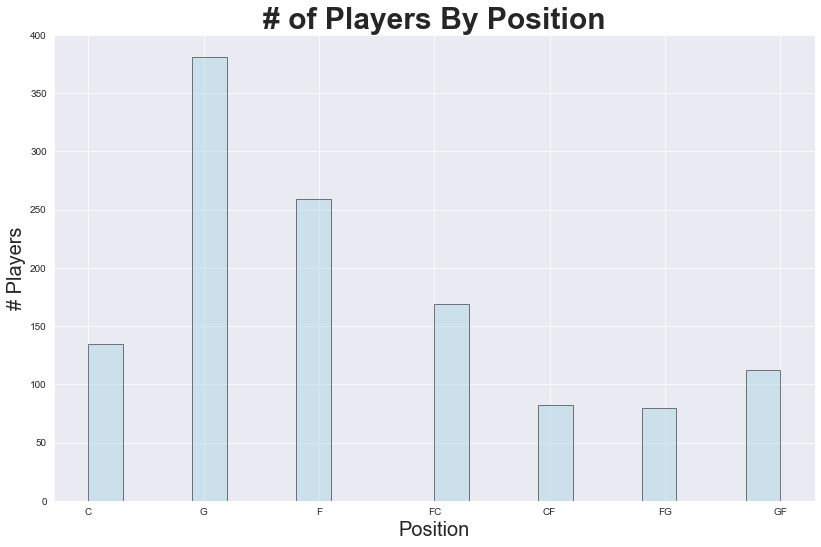

In [27]:
#sns.set_style('darkgrid')
#fig = plt.figure(figsize = (30,30))
#fig.subplots_adjust(hspace = .25)
##ax1 and ax2 explain the relationship between attending college and having a longer than average career
#ax1 = fig.add_subplot(321)
#ax1.hist(df_eligible['Position'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
#ax1.set_xlabel('Position', fontsize = 20)
#ax1.set_ylabel('# Players',fontsize = 20)
#ax1.set_title('# of Players By Position',fontsize = 30,fontweight='bold')
#
#

In [73]:
df_eligible['Height'] = (df_eligible['Height'].str.strip('cm').astype(int))

AttributeError: Can only use .str accessor with string values!

In [74]:
df_eligible['Weight'] = (df_eligible['Weight'].str.strip('kg').astype(int))

/Users/joeybillet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
df_eligible['Avg Games Played']= df_eligible['Games']/df_eligible['Tenure']

/Users/joeybillet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
df_eligible['Avg Games Played'].mean()

61.22609014409715

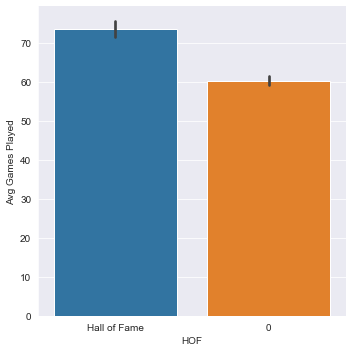

In [102]:
sns.catplot(x="HOF", y="Avg Games Played", data=df_eligible, kind='bar');

Avg height by position

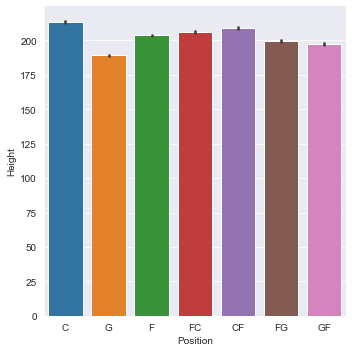

In [93]:
sns.catplot(x="Position", y="Height", data=df_eligible, kind='bar');

What Position gets voted to the HOF more?

In [97]:
df_HOF= df_eligible[df_eligible['HOF']=='Hall of Fame']

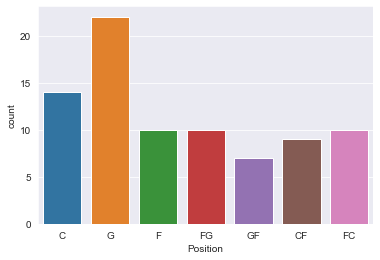

In [100]:
sns.countplot(x="Position", data= df_HOF);

Average Tenure of a HOF

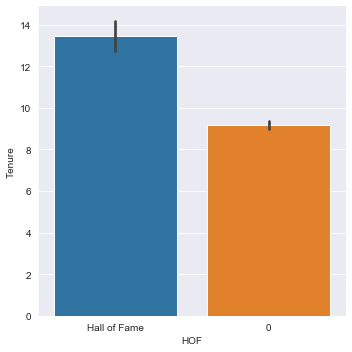

In [99]:
sns.catplot(x="HOF", y="Tenure", data=df_eligible, kind='bar');